################################################################################
PHASE 1 : CHARGEMENT ET ANALYSE EXPLORATOIRE DES DONNÉES
################################################################################

 Chargement des données d'entraînement...
Données chargées : 20631 lignes, 26 colonnes
Nombre de moteurs : 100

 Aperçu des données :
   unit_nr  time_cycles  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0        1            1       -0.0007       -0.0004         100.0    518.67   
1        1            2        0.0019       -0.0003         100.0    518.67   
2        1            3       -0.0043        0.0003         100.0    518.67   
3        1            4        0.0007        0.0000         100.0    518.67   
4        1            5       -0.0019       -0.0002         100.0    518.67   
5        1            6       -0.0043       -0.0001         100.0    518.67   
6        1            7        0.0010        0.0001         100.0    518.67   
7        1    

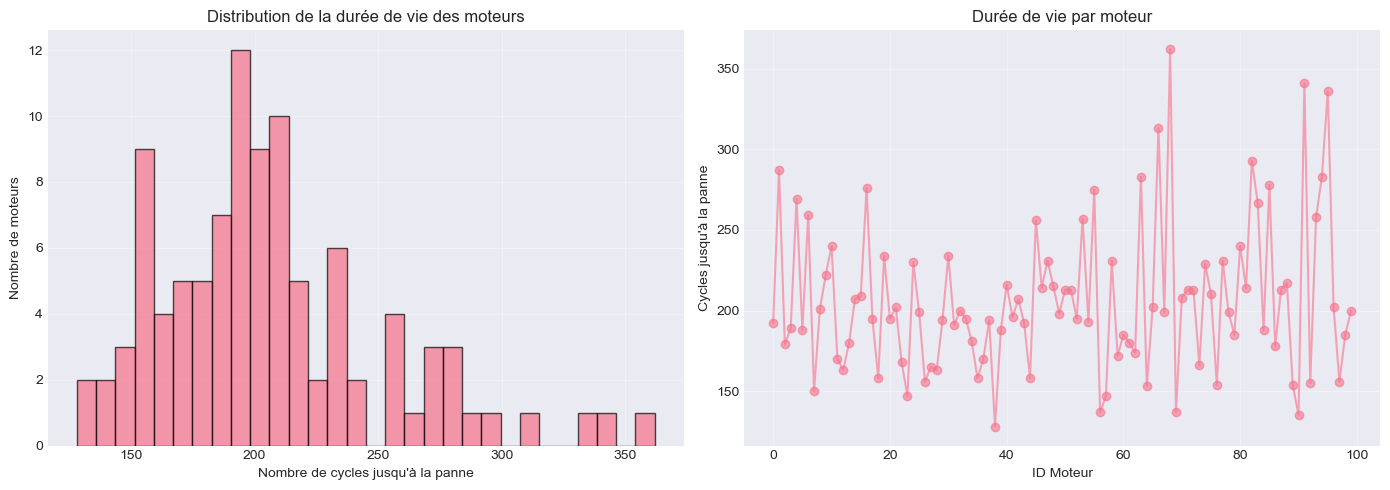

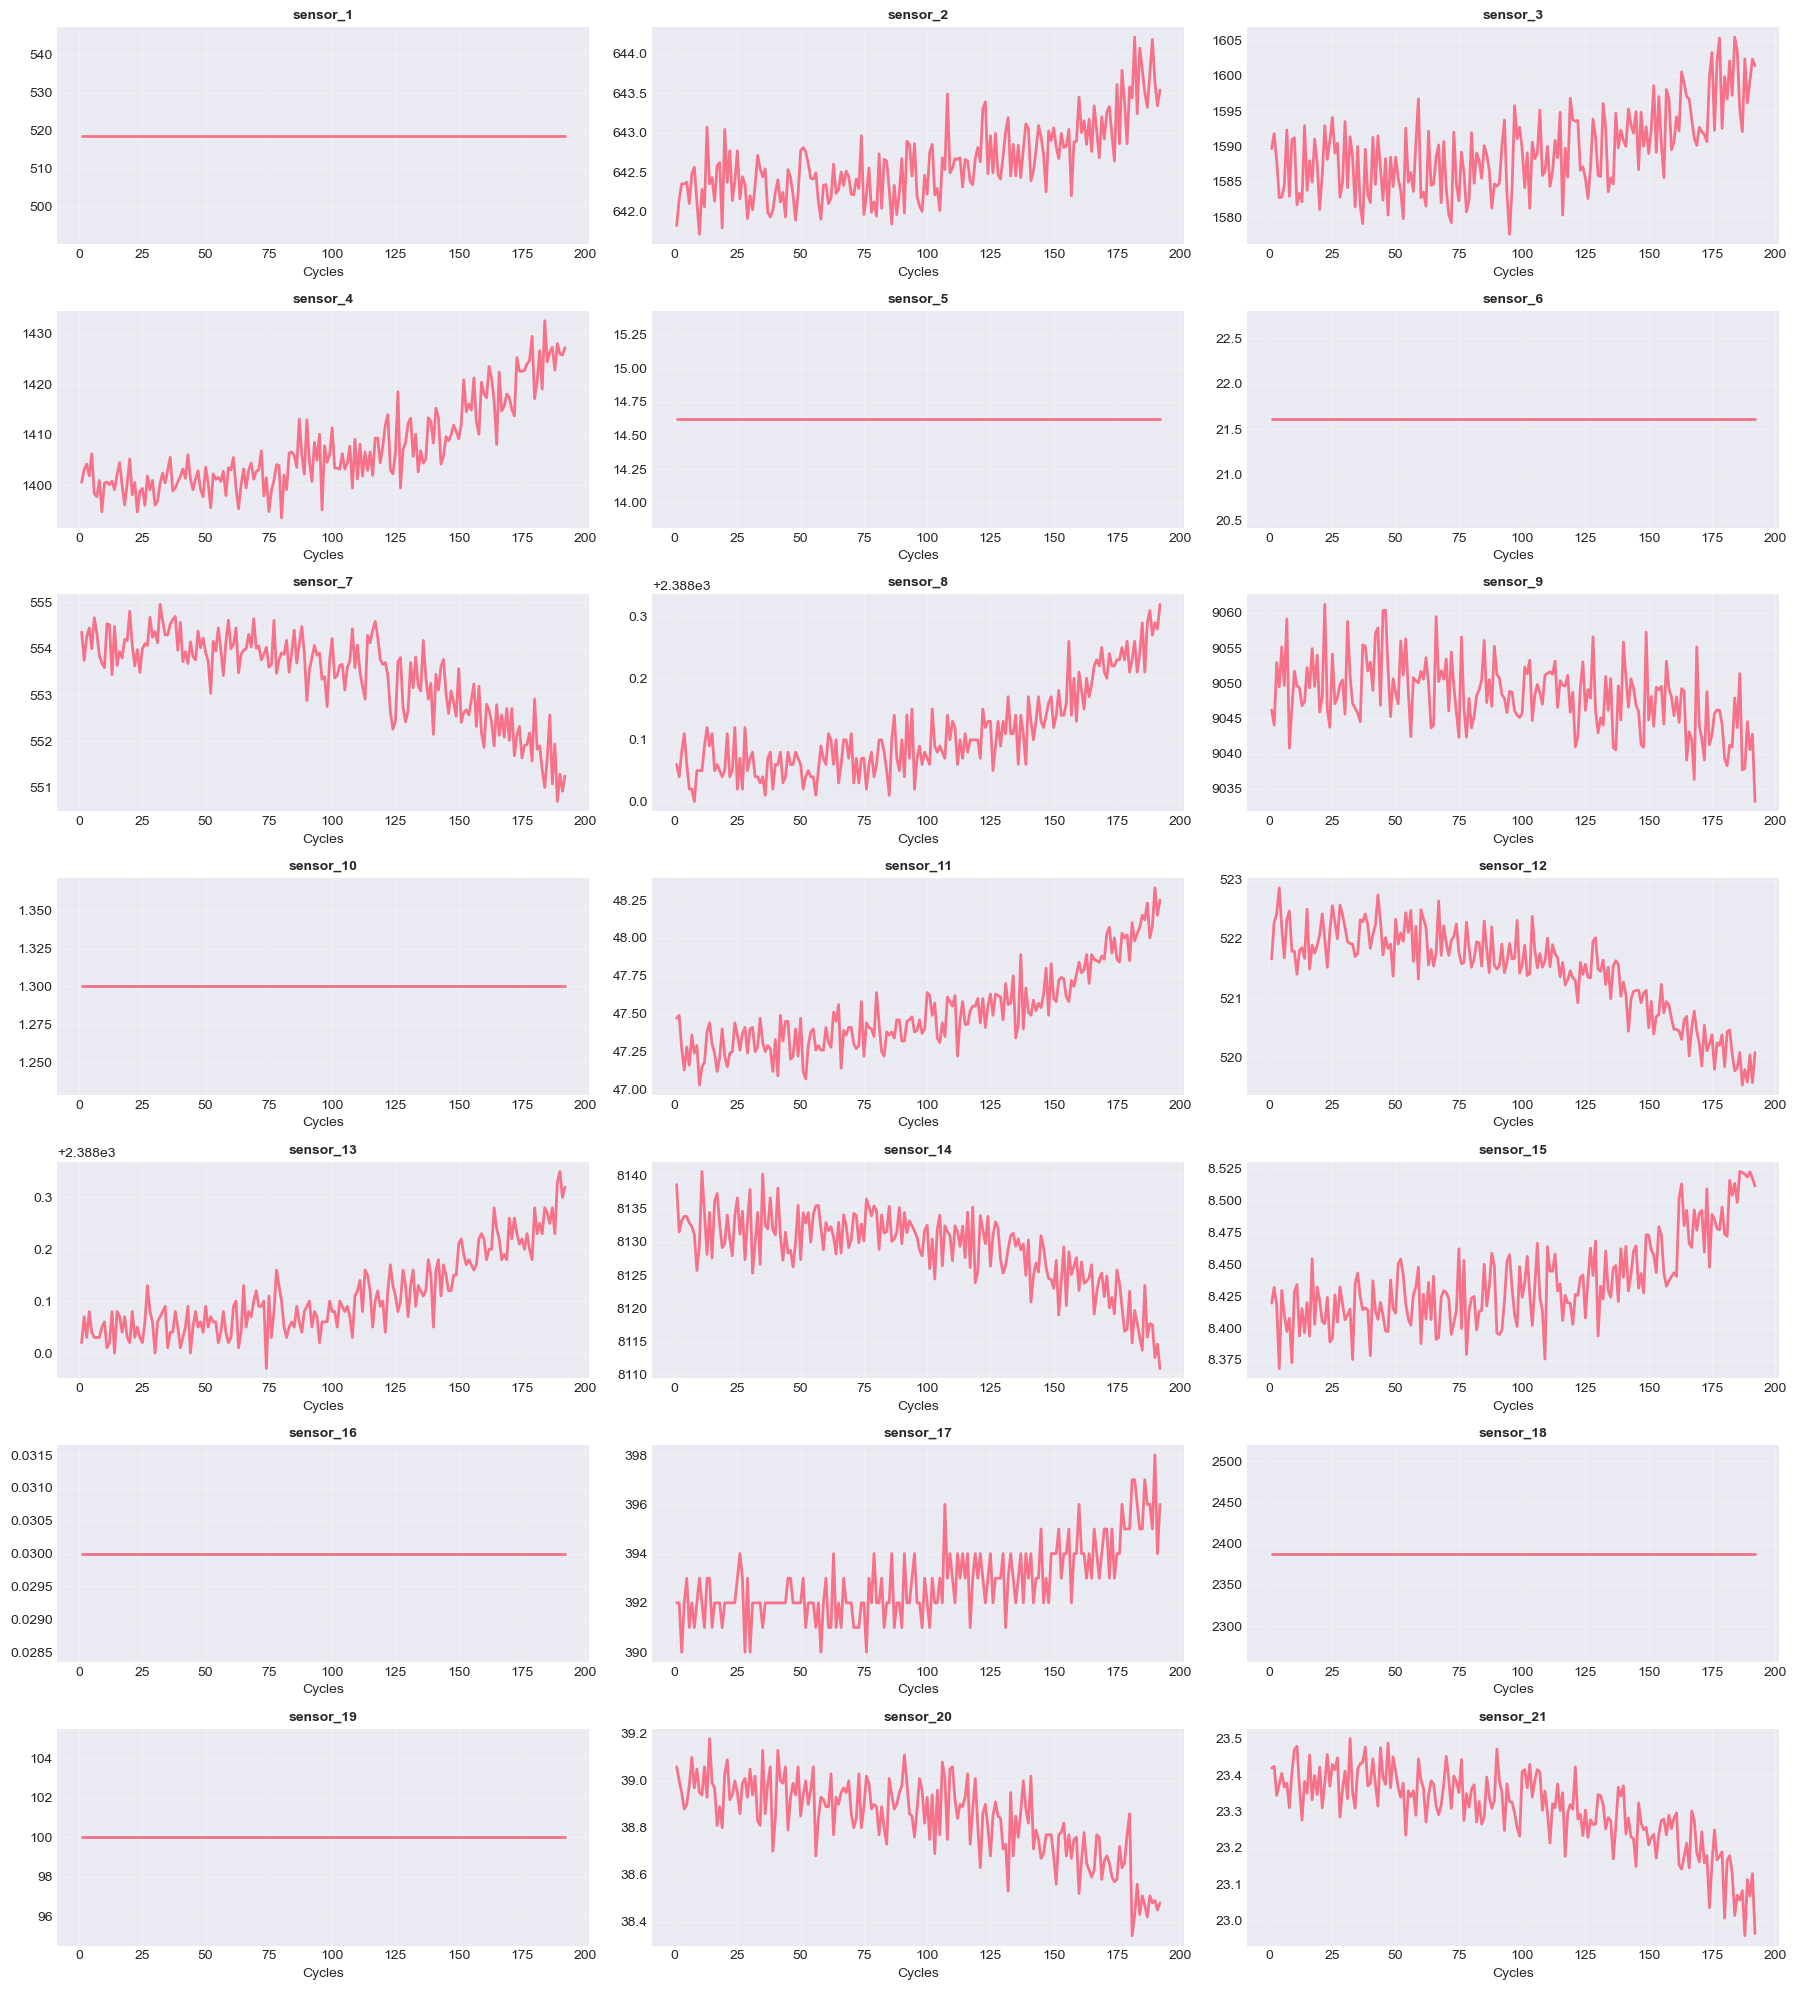

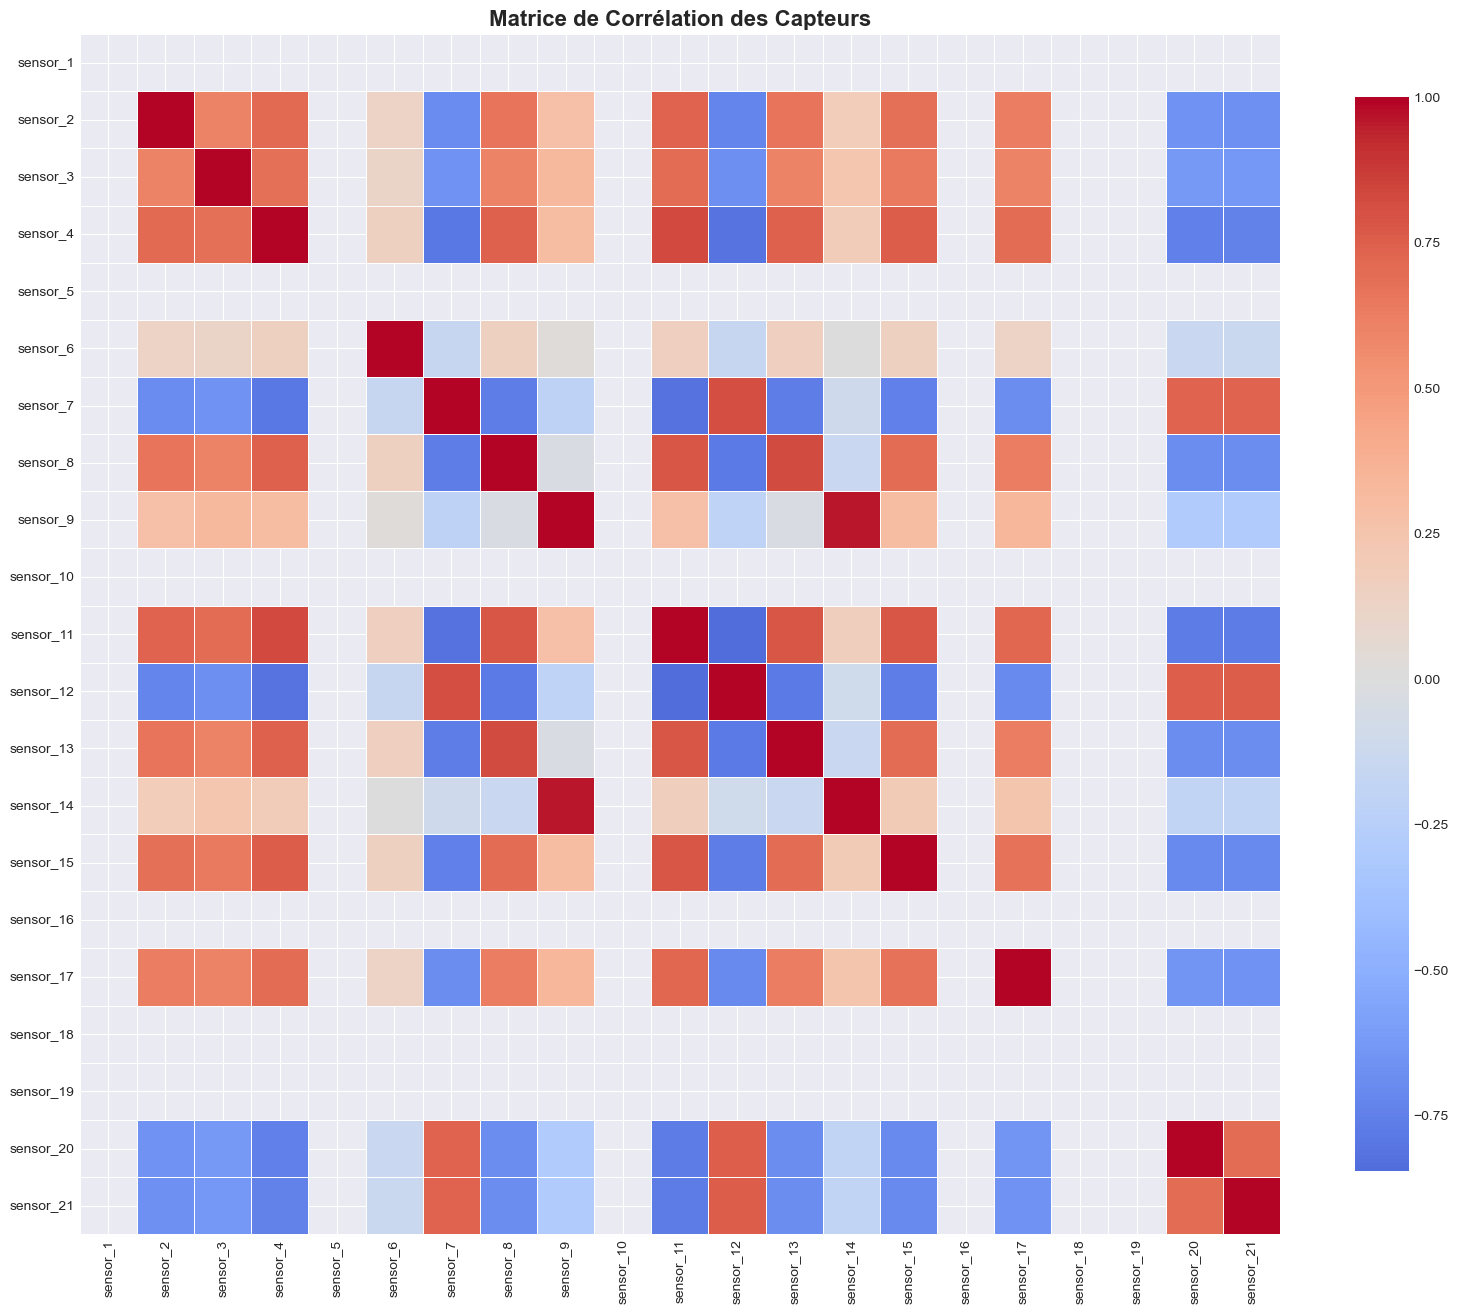

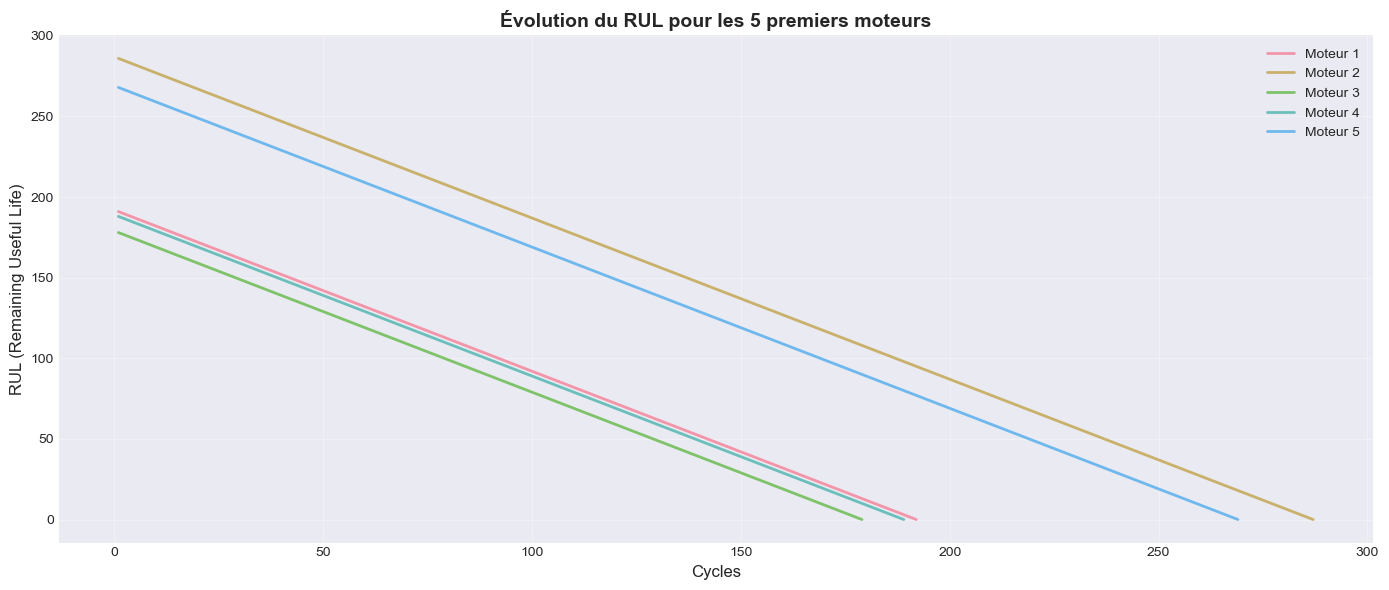

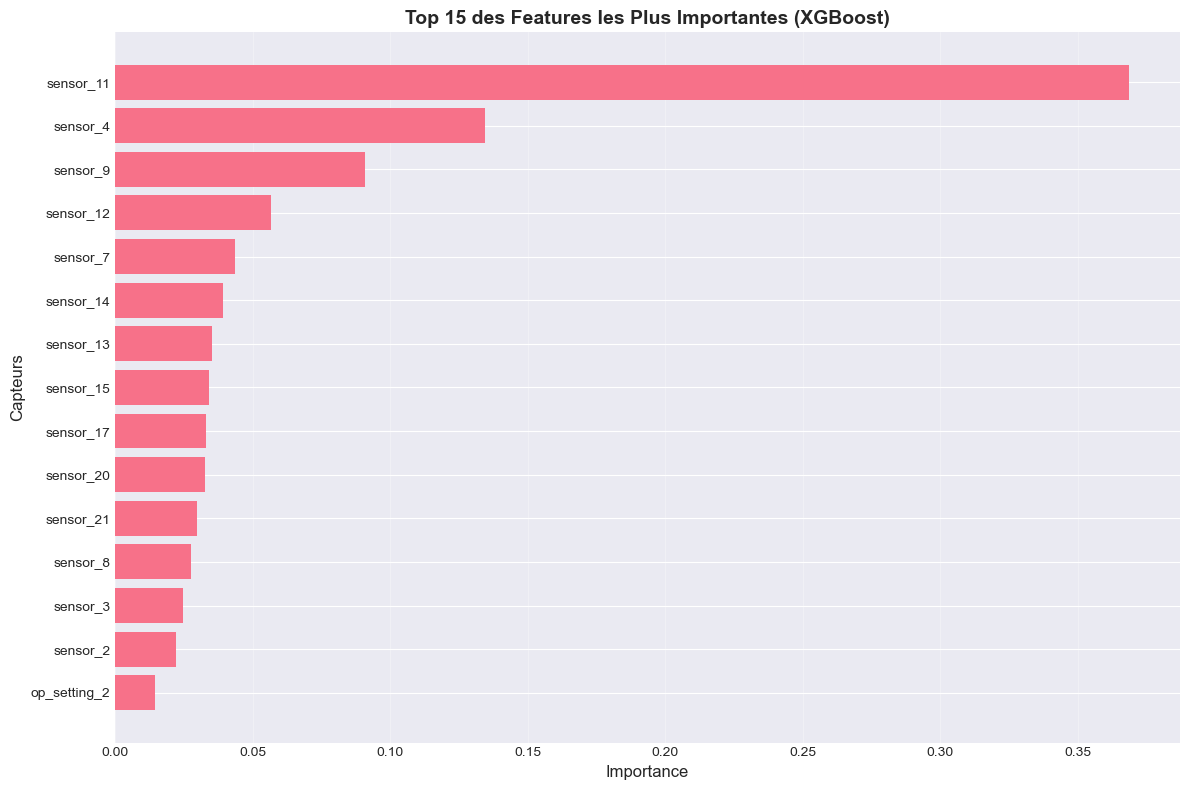

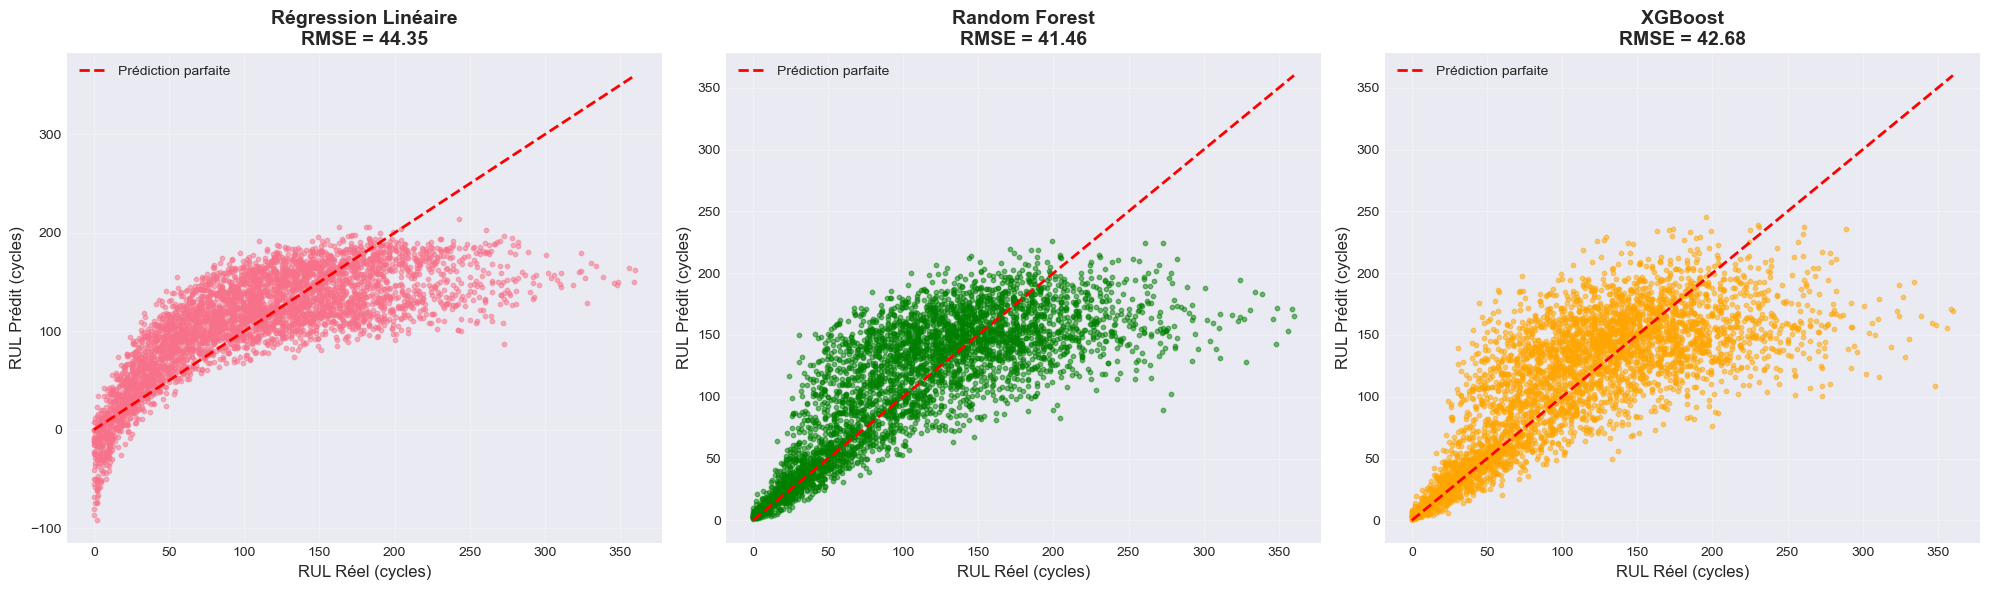

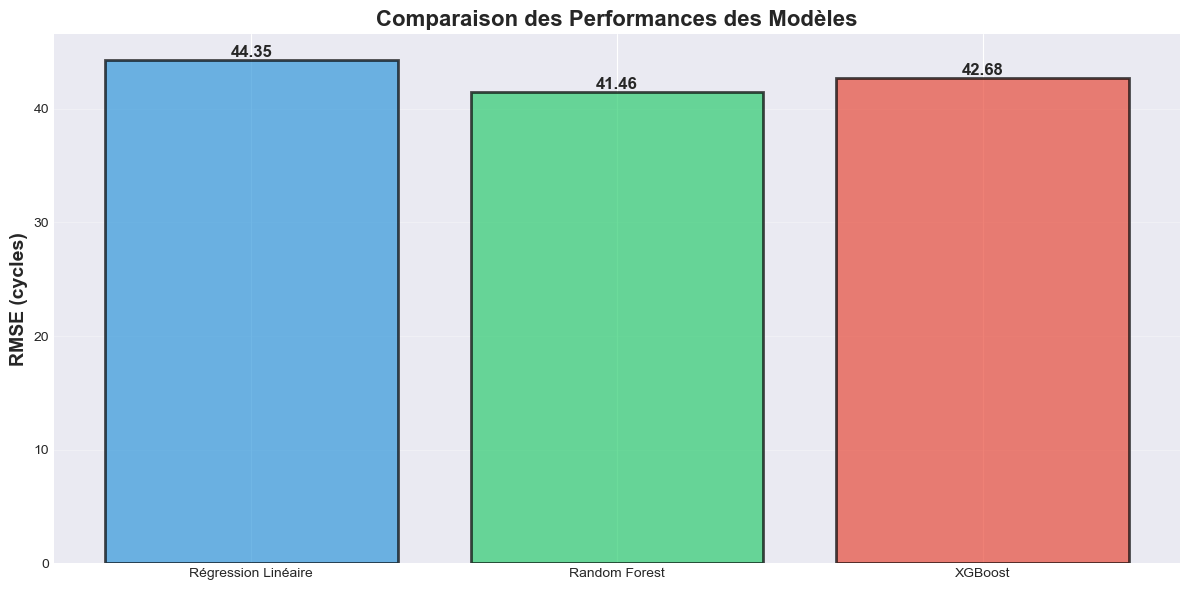

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#################################################
# PHASE 1 : CHARGEMENT ET ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
#################################################

print("#" * 80)
print("PHASE 1 : CHARGEMENT ET ANALYSE EXPLORATOIRE DES DONNÉES")
print("#" * 80)


# Définition des noms de colonnes (car les fichiers n'ont pas d'en-tête)
column_names = ['unit_nr', 'time_cycles']
column_names += ['op_setting_' + str(i) for i in range(1, 4)]
column_names += ['sensor_' + str(i) for i in range(1, 22)]

# Chargement des données d'entraînement
print("\n Chargement des données d'entraînement...")

train_data = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)

print(f"Données chargées : {train_data.shape[0]} lignes, {train_data.shape[1]} colonnes")
print(f"Nombre de moteurs : {train_data['unit_nr'].nunique()}")

# Affichage des premières lignes
print("\n Aperçu des données :")
print(train_data.head(10))

# Statistiques descriptives
print("\n Statistiques descriptives :")
print(train_data.describe())

# Visualisation 1 : Évolution des cycles par moteur
print("\n Analyse de la durée de vie des moteurs...")
max_cycles = train_data.groupby('unit_nr')['time_cycles'].max()
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(max_cycles, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Nombre de cycles jusqu\'à la panne')
plt.ylabel('Nombre de moteurs')
plt.title('Distribution de la durée de vie des moteurs')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(max_cycles.values, 'o-', alpha=0.6)
plt.xlabel('ID Moteur')
plt.ylabel('Cycles jusqu\'à la panne')
plt.title('Durée de vie par moteur')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('duree_vie_moteurs.png', dpi=300, bbox_inches='tight')
print(" Graphique sauvegardé : duree_vie_moteurs.png")

# Visualisation 2 : Évolution des capteurs pour un moteur spécifique
print("\n Analyse de l'évolution des capteurs pour le moteur #1...")
moteur_1 = train_data[train_data['unit_nr'] == 1]
sensor_cols = [col for col in train_data.columns if 'sensor_' in col]

fig, axes = plt.subplots(7, 3, figsize=(18, 20))
axes = axes.flatten()

for idx, sensor in enumerate(sensor_cols):
    axes[idx].plot(moteur_1['time_cycles'], moteur_1[sensor], linewidth=2)
    axes[idx].set_title(f'{sensor}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Cycles')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evolution_capteurs_moteur1.png', dpi=300, bbox_inches='tight')
print("Graphique sauvegardé : evolution_capteurs_moteur1.png")

# Identification des capteurs constants (inutiles pour la prédiction)
print("\n Identification des capteurs constants...")
constant_sensors = []
for sensor in sensor_cols:
    if train_data[sensor].std() < 0.01:  # Écart-type très faible = capteur constant
        constant_sensors.append(sensor)
        print(f"   {sensor} est constant (std = {train_data[sensor].std():.6f})")

print(f"\n {len(constant_sensors)} capteurs constants identifiés")

# Matrice de corrélation
print("\n Calcul de la matrice de corrélation...")
correlation_matrix = train_data[sensor_cols].corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Capteurs', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('matrice_correlation.png', dpi=300, bbox_inches='tight')
print(" Graphique sauvegardé : matrice_correlation.png")

#################################################
# PHASE 2 : PRÉTRAITEMENT ET FEATURE ENGINEERING
#################################################

print("\n" + "#" * 80)
print("PHASE 2 : PRÉTRAITEMENT ET CALCUL DU RUL")
print("#" * 80)

# CALCUL DU RUL (Remaining Useful Life)
print("\n  Calcul du RUL pour chaque cycle...")

# Pour chaque moteur, on trouve son cycle maximal (moment de la panne)
max_cycles_per_engine = train_data.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycles_per_engine.columns = ['unit_nr', 'max_cycle']

# On fusionne avec les données d'origine
train_data = train_data.merge(max_cycles_per_engine, on='unit_nr', how='left')

# Calcul du RUL : RUL = Cycle_Max - Cycle_Actuel
train_data['RUL'] = train_data['max_cycle'] - train_data['time_cycles']

print(" Colonne RUL créée avec succès")
print(f"\n Exemple de RUL pour le moteur #1 :")
print(train_data[train_data['unit_nr'] == 1][['unit_nr', 'time_cycles', 'max_cycle', 'RUL']].head(10))

# Visualisation du RUL
plt.figure(figsize=(14, 6))
for i in range(1, 6):  # Afficher 5 premiers moteurs
    engine_data = train_data[train_data['unit_nr'] == i]
    plt.plot(engine_data['time_cycles'], engine_data['RUL'], 
             label=f'Moteur {i}', linewidth=2, alpha=0.7)

plt.xlabel('Cycles', fontsize=12)
plt.ylabel('RUL (Remaining Useful Life)', fontsize=12)
plt.title('Évolution du RUL pour les 5 premiers moteurs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('evolution_rul.png', dpi=300, bbox_inches='tight')
print(" Graphique sauvegardé : evolution_rul.png")

# NETTOYAGE DES DONNÉES
print("\n Nettoyage des données...")

# Suppression des capteurs constants
print(f"   Suppression de {len(constant_sensors)} capteurs constants")
train_cleaned = train_data.drop(columns=constant_sensors)

# Suppression de la colonne max_cycle (temporaire, plus nécessaire)
train_cleaned = train_cleaned.drop(columns=['max_cycle'])

print(f"Dataset nettoyé : {train_cleaned.shape[1]} colonnes restantes")

# NORMALISATION DES DONNÉES
print("\n Normalisation des données (MinMaxScaler)...")

# Colonnes à normaliser (tous les capteurs et paramètres opérationnels)
cols_to_normalize = [col for col in train_cleaned.columns 
                     if col not in ['unit_nr', 'time_cycles', 'RUL']]

scaler = MinMaxScaler()
train_cleaned[cols_to_normalize] = scaler.fit_transform(train_cleaned[cols_to_normalize])

print(" Normalisation terminée (valeurs entre 0 et 1)")
print(f"\n Aperçu des données normalisées :")
print(train_cleaned.head())

##################################################
# PHASE 3 : MODÉLISATION (MACHINE LEARNING)
##################################################

print("\n" + "#" * 80)
print("PHASE 3 : MODÉLISATION ET ENTRAÎNEMENT")
print("#" * 80)

# Préparation des données pour l'entraînement
print("\n Préparation des features (X) et de la cible (y)...")

# X = Features (on enlève unit_nr, time_cycles, et RUL)
X = train_cleaned.drop(columns=['unit_nr', 'time_cycles', 'RUL'])
# y = Target (le RUL qu'on veut prédire)
y = train_cleaned['RUL']

print(f" Features (X) : {X.shape[1]} colonnes, {X.shape[0]} échantillons")
print(f" Target (y) : {y.shape[0]} échantillons")

# Division Train/Test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n Données d'entraînement : {X_train.shape[0]} échantillons")
print(f" Données de test : {X_test.shape[0]} échantillons")

##################################################
# MODÈLE 1 : RÉGRESSION LINÉAIRE (BASELINE)
##################################################

print("\n" + "-" * 60)
print("MODÈLE 1 : RÉGRESSION LINÉAIRE (Baseline)")
print("-" * 60)

print("\n Entraînement du modèle de régression linéaire...")
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
print("Entraînement terminé")

# Prédictions
y_pred_lr = model_lr.predict(X_test)

# Évaluation
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\n RÉSULTATS - Régression Linéaire :")
print(f"  • RMSE (Root Mean Square Error) : {rmse_lr:.2f} cycles")
print(f"  • MAE (Mean Absolute Error)      : {mae_lr:.2f} cycles")
print(f"  • R² Score                       : {r2_lr:.4f}")

##################################################
# MODÈLE 2 : RANDOM FOREST (AVANCÉ)
##################################################

print("\n" + "-" * 60)
print("MODÈLE 2 : RANDOM FOREST REGRESSOR (Avancé)")
print("-" * 60)

print("\n Entraînement du Random Forest (100 arbres)...")
model_rf = RandomForestRegressor(n_estimators=100, max_depth=20, 
                                 random_state=42, n_jobs=-1, verbose=0)
model_rf.fit(X_train, y_train)
print(" Entraînement terminé")

# Prédictions
y_pred_rf = model_rf.predict(X_test)

# Évaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n RÉSULTATS - Random Forest :")
print(f"  • RMSE (Root Mean Square Error) : {rmse_rf:.2f} cycles")
print(f"  • MAE (Mean Absolute Error)      : {mae_rf:.2f} cycles")
print(f"  • R² Score                       : {r2_rf:.4f}")

# Importance des features
print("\n Top 10 des capteurs les plus importants (Random Forest) :")
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': model_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_rf.head(10).to_string(index=False))

##################################################
# MODÈLE 3 : XGBOOST (TRÈS PERFORMANT)
##################################################

print("\n" + "-" * 60)
print("MODÈLE 3 : XGBOOST REGRESSOR (État de l'art)")
print("-" * 60)

try:
    import xgboost as xgb
    
    print("\n Entraînement du XGBoost...")
    model_xgb = xgb.XGBRegressor(
        n_estimators=200,           # Nombre d'arbres
        max_depth=8,                # Profondeur maximale
        learning_rate=0.1,          # Taux d'apprentissage
        subsample=0.8,              # Échantillonnage des données
        colsample_bytree=0.8,       # Échantillonnage des features
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    model_xgb.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)],
                  verbose=False)
    print(" Entraînement terminé")
    
    # Prédictions
    y_pred_xgb = model_xgb.predict(X_test)
    
    # Évaluation
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    
    print(f"\n RÉSULTATS - XGBoost :")
    print(f"  • RMSE (Root Mean Square Error) : {rmse_xgb:.2f} cycles")
    print(f"  • MAE (Mean Absolute Error)      : {mae_xgb:.2f} cycles")
    print(f"  • R² Score                       : {r2_xgb:.4f}")
    
    # Importance des features XGBoost
    print("\n Top 10 des capteurs les plus importants (XGBoost) :")
    feature_importance_xgb = pd.DataFrame({
        'feature': X.columns,
        'importance': model_xgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance_xgb.head(10).to_string(index=False))
    
    # Visualisation de l'importance des features (XGBoost)
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_xgb.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Capteurs', fontsize=12)
    plt.title('Top 15 des Features les Plus Importantes (XGBoost)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
    print("\n Graphique sauvegardé : feature_importance_xgboost.png")
    
    xgb_available = True
    
except ImportError:
    print("\n  XGBoost n'est pas installé.")
    print("   Pour l'installer : pip install xgboost")
    print("   Le modèle XGBoost sera ignoré dans l'analyse.")
    xgb_available = False
    rmse_xgb, mae_xgb, r2_xgb = None, None, None
    y_pred_xgb = None

##################################################
# PHASE 4 : VISUALISATION DES RÉSULTATS
##################################################

print("\n" + "#" * 80)
print("PHASE 4 : VISUALISATION DES RÉSULTATS")
print("#" * 80)

# Comparaison des modèles
if xgb_available:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Régression Linéaire
    axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=10)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', linewidth=2, label='Prédiction parfaite')
    axes[0].set_xlabel('RUL Réel (cycles)', fontsize=12)
    axes[0].set_ylabel('RUL Prédit (cycles)', fontsize=12)
    axes[0].set_title(f'Régression Linéaire\nRMSE = {rmse_lr:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Random Forest
    axes[1].scatter(y_test, y_pred_rf, alpha=0.5, s=10, color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', linewidth=2, label='Prédiction parfaite')
    axes[1].set_xlabel('RUL Réel (cycles)', fontsize=12)
    axes[1].set_ylabel('RUL Prédit (cycles)', fontsize=12)
    axes[1].set_title(f'Random Forest\nRMSE = {rmse_rf:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # XGBoost
    axes[2].scatter(y_test, y_pred_xgb, alpha=0.5, s=10, color='orange')
    axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', linewidth=2, label='Prédiction parfaite')
    axes[2].set_xlabel('RUL Réel (cycles)', fontsize=12)
    axes[2].set_ylabel('RUL Prédit (cycles)', fontsize=12)
    axes[2].set_title(f'XGBoost\nRMSE = {rmse_xgb:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Régression Linéaire
    axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=10)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', linewidth=2, label='Prédiction parfaite')
    axes[0].set_xlabel('RUL Réel (cycles)', fontsize=12)
    axes[0].set_ylabel('RUL Prédit (cycles)', fontsize=12)
    axes[0].set_title(f'Régression Linéaire\nRMSE = {rmse_lr:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Random Forest
    axes[1].scatter(y_test, y_pred_rf, alpha=0.5, s=10, color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', linewidth=2, label='Prédiction parfaite')
    axes[1].set_xlabel('RUL Réel (cycles)', fontsize=12)
    axes[1].set_ylabel('RUL Prédit (cycles)', fontsize=12)
    axes[1].set_title(f'Random Forest\nRMSE = {rmse_rf:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparaison_modeles.png', dpi=300, bbox_inches='tight')
print("\n Graphique sauvegardé : comparaison_modeles.png")

# Tableau comparatif final
print("\n" + "#" * 80)
print("TABLEAU COMPARATIF FINAL")
print("#" * 80)

if xgb_available:
    comparison_df = pd.DataFrame({
        'Modèle': ['Régression Linéaire', 'Random Forest', 'XGBoost'],
        'RMSE': [f'{rmse_lr:.2f}', f'{rmse_rf:.2f}', f'{rmse_xgb:.2f}'],
        'MAE': [f'{mae_lr:.2f}', f'{mae_rf:.2f}', f'{mae_xgb:.2f}'],
        'R² Score': [f'{r2_lr:.4f}', f'{r2_rf:.4f}', f'{r2_xgb:.4f}']
    })
    
    # Déterminer le meilleur modèle
    best_model_idx = [rmse_lr, rmse_rf, rmse_xgb].index(min([rmse_lr, rmse_rf, rmse_xgb]))
    best_model_name = ['Régression Linéaire', 'Random Forest', 'XGBoost'][best_model_idx]
    best_rmse = min([rmse_lr, rmse_rf, rmse_xgb])
    
else:
    comparison_df = pd.DataFrame({
        'Modèle': ['Régression Linéaire', 'Random Forest'],
        'RMSE': [f'{rmse_lr:.2f}', f'{rmse_rf:.2f}'],
        'MAE': [f'{mae_lr:.2f}', f'{mae_rf:.2f}'],
        'R² Score': [f'{r2_lr:.4f}', f'{r2_rf:.4f}']
    })
    
    # Déterminer le meilleur modèle
    best_model_idx = [rmse_lr, rmse_rf].index(min([rmse_lr, rmse_rf]))
    best_model_name = ['Régression Linéaire', 'Random Forest'][best_model_idx]
    best_rmse = min([rmse_lr, rmse_rf])

print("\n" + comparison_df.to_string(index=False))

# Graphique comparatif des performances
plt.figure(figsize=(12, 6))
models = comparison_df['Modèle'].tolist()
rmse_values = [float(x) for x in comparison_df['RMSE'].tolist()]
colors = ['#3498db', '#2ecc71', '#e74c3c'][:len(models)]

bars = plt.bar(models, rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('RMSE (cycles)', fontsize=14, fontweight='bold')
plt.title('Comparaison des Performances des Modèles', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, rmse_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('comparaison_rmse.png', dpi=300, bbox_inches='tight')
print("\n Graphique sauvegardé : comparaison_rmse.png")

# Recommandation
print("\n" + "#" * 80)
print("CONCLUSION ET RECOMMANDATION")
print("#" * 80)

print(f"\n MEILLEUR MODÈLE : {best_model_name}")
print(f"   • RMSE = {best_rmse:.2f} cycles")

if xgb_available and best_model_name == 'XGBoost':
    improvement_vs_lr = ((rmse_lr - rmse_xgb) / rmse_lr * 100)
    improvement_vs_rf = ((rmse_rf - rmse_xgb) / rmse_rf * 100)
    print(f"   • Amélioration vs Régression Linéaire : {improvement_vs_lr:.1f}%")
    print(f"   • Amélioration vs Random Forest : {improvement_vs_rf:.1f}%")
elif best_model_name == 'Random Forest':
    improvement_vs_lr = ((rmse_lr - rmse_rf) / rmse_lr * 100)
    print(f"   • Amélioration vs Régression Linéaire : {improvement_vs_lr:.1f}%")
    
print("\n Recommandation : Utiliser " + best_model_name + " pour la prédiction du RUL")
    
print("\n  Pour une utilisation en production :")
print("  • Tester sur le fichier test_FD001.txt avec RUL_FD001.txt")
print("  • Viser un RMSE < 20 cycles pour une fiabilité acceptable")
print("  • Implémenter un système d'alertes pour RUL < seuil critique")
print("  • Considérer des modèles Deep Learning (LSTM) pour capturer les séquences temporelles")

print("\n ANALYSE DES PERFORMANCES :")
if best_rmse < 20:
    print("   Excellentes performances (RMSE < 20) - Prêt pour des tests pilotes")
elif best_rmse < 30:
    print("   Performances correctes (20 < RMSE < 30) - Amélioration recommandée")
else:
    print("   Performances insuffisantes (RMSE > 30) - Nécessite optimisation")

print("\n" + "#" * 80)
print("FIN DE L'ANALYSE")
print("#" * 80)